In [1]:
import flwr as fl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
import random
import os
from sklearn.svm import SVC
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from flwr.common import parameters_to_ndarrays
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-20 21:15:06,688	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# --- CNN 모델 (클라이언트 용) ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class DAGMM(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(DAGMM, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: feature -> latent
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 60),
            nn.Tanh(),
            nn.Linear(60, 30),
            nn.Tanh(),
            nn.Linear(30, latent_dim)
        )

        # Decoder: latent -> reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 30),
            nn.Tanh(),
            nn.Linear(30, 60),
            nn.Tanh(),
            nn.Linear(60, input_dim)
        )

        # Estimation network: latent + reconstruction error -> gamma (energy)
        self.estimation = nn.Sequential(
            nn.Linear(latent_dim + 1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
            nn.Sigmoid()  # Optional depending on energy interpretation
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        recon_error = torch.mean((x - reconstructed) ** 2, dim=1, keepdim=True)
        z = torch.cat([latent, recon_error], dim=1)
        energy = self.estimation(z)
        return latent, reconstructed, energy

    def compute_loss(self, x, reconstructed, energy):
        recon_loss = F.mse_loss(reconstructed, x, reduction="mean")
        energy_loss = energy.mean()
        return recon_loss + 0.1 * energy_loss  # λ 조정 가능


In [4]:
# --- FL 클라이언트들 ---
class FederatedClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_loader, test_loader, epochs=10):
        self.cid = cid
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = nn.CrossEntropyLoss()
        self.model.to(self.device)


    def get_parameters(self, config): return [p.cpu().detach().numpy() for p in self.model.parameters()]
    
    def set_parameters(self, parameters):
        for p, new_p in zip(self.model.parameters(), parameters):
            p.data = torch.tensor(new_p, dtype=torch.float32, device=device)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        for _ in range(self.epochs):
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(self.model(x), y)
                loss.backward()
                optimizer.step()
        return self.get_parameters(config), len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total

        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}  # ✅ 반드시 3개 반환


In [5]:
# --- 클라이언트 행동 변종 ---
class LazyClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        super().__init__(cid, model, train_loader, test_loader, epochs=5)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        for _ in range(5):  # 적게 학습
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(self.model(x), y)
                loss.backward()
                optimizer.step()
        return self.get_parameters(config), len(self.train_loader.dataset), {"cid": self.cid}
    
    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total
        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}

class RandomClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        super().__init__(cid, model, train_loader, test_loader)
        
    def fit(self, parameters, config):
        shape_params = [np.random.randn(*p.shape).astype(np.float32) for p in parameters]
        return shape_params, len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total
        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}
    
class EchoClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        super().__init__(cid, model, train_loader, test_loader)
        self.buffer = []
        self.round = 0

    def fit(self, parameters, config):
        self.round += 1
        self.buffer.append(parameters)

        if self.round <= 2:
            print(f"[EchoClient] Round {self.round}: returning current parameters (initial phase)")
            return parameters, len(self.train_loader.dataset), {"cid": self.cid}
        else:
            echoed = self.buffer[-3]  # 2 라운드 이전의 파라미터 반환
            print(f"[EchoClient] Round {self.round}: returning parameters from round {self.round - 2}")
            return echoed, len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total
        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}

class SmallClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        # train_loader의 데이터 수가 적어야 비정상으로 간주되도록!
        small_train_loader = torch.utils.data.DataLoader(
            list(train_loader.dataset)[:200],  # 작은 부분만 사용
            batch_size=32, shuffle=True
        )
        super().__init__(cid, model, small_train_loader, test_loader, epochs=10)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        for _ in range(self.epochs):
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(self.model(x), y)
                loss.backward()
                optimizer.step()
        return self.get_parameters(config), len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total

        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}  # ✅ 반드시 3개 반환

In [6]:
# --- 클라이언트 분류 ---
def classify_client(parameters, dagmm_model, svm_model):
    ndarrays = parameters_to_ndarrays(parameters)
    flat = np.concatenate([p.flatten() for p in ndarrays])
    with torch.no_grad():
        latent, _, _ = dagmm_model(torch.tensor(flat, dtype=torch.float32).unsqueeze(0).to(device))
    return svm_model.predict(latent.cpu().numpy())[0]

In [7]:
def make_client(cid, partition, label):
    model = SimpleCNN()
    train = DataLoader(partition, batch_size=32, shuffle=True)
    test = DataLoader(partition, batch_size=32, shuffle=False)

    if label == "lazy":
        client = LazyClient(cid, model, train, test)
    elif label == "random":
        client = RandomClient(cid, model, train, test)
    elif label == "echo":
        client = EchoClient(cid, model, train, test)
    elif label == "small":
        client = SmallClient(cid, model, train, test)
    else:
        client = FederatedClient(cid, model, train, test)

    client.true_label = label  # 🔥 반드시 추가!
    return client


In [8]:
# --- 클라이언트 풀 + 페널티 관리 ---
class PunishedClientPool:
    def __init__(self, clients, data_partitions):
        # PunishedClientPool에서
        self.clients = {str(i): c for i, c in enumerate(clients)}
        self.data_partitions = data_partitions  # 🔹 여기 추가!
        self.client_mapping = {
            "normal": FederatedClient,
            "lazy": LazyClient,
            "random": RandomClient,
            "echo": EchoClient,
            "small": SmallClient,
        }
        
    def get_client_by_id(self, cid):
        # 새로운 클라이언트는 "new_X_Y" 형식이므로 리스트 인덱스로 접근할 수 없음
        if isinstance(cid, str) and cid.startswith("new_"):
            return None  # 또는 raise ValueError("Dynamically added client is not tracked.")
        
        try:
            return self.clients[str(cid)]
        except (ValueError, IndexError):
            return None  # 혹은 적절한 에러 처리


    def update_clients(self, results, dagmm, svm, round_num):
        for i, (cid, res) in enumerate(results):
            pred = classify_client(res.parameters, dagmm, svm)

            # 🔹 Echo는 3라운드 이후부터만 패널티
            if pred != "normal" and not (pred == "echo" and round_num < 3):
                self.penalties[i] += 1

        for i, p in enumerate(self.penalties):
            if p >= 6:
                print(f"[INFO] Removing malicious client {i} (penalty {6})")
                new_label = random.choice(self.labels)
                self.clients[i] = make_client(i, self.data_partitions[i], new_label)
                self.penalties[i] = 0  # reset

    def get_client_fn(self):
        return lambda cid: self.clients[str(cid)].to_client()


In [9]:
import torch.optim as optim
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

def train_dagmm_supervised(data, labels, input_dim, num_classes=6, epochs=100, lr=0.001):
    model = DAGMM(input_dim).to(device)
    classifier = nn.Linear(model.latent_dim, num_classes).to(device)
    optimizer = optim.AdamW(list(model.parameters()) + list(classifier.parameters()), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    # 클래스별 오버샘플 비율 설정 (예: 클래스 1, 5, 6을 더 많이 보정)
    oversample_ratios = {1: 3, 5: 3, 6: 2}  # 필요시 조정 가능

    # 원본 클래스 분포
    class_counts = Counter(labels)
    augmented_data, augmented_labels = [], []

    for cls in np.unique(labels):
        cls_indices = np.where(labels == cls)[0]
        cls_data = data[cls_indices]
        cls_labels = labels[cls_indices]
        repeat_factor = oversample_ratios.get(cls, 1)
        for _ in range(repeat_factor):
            augmented_data.append(cls_data)
            augmented_labels.append(cls_labels)

    data_aug = np.vstack(augmented_data)
    labels_aug = np.concatenate(augmented_labels)

    print("[INFO] Sample count per class (after oversampling):", dict(Counter(labels_aug)))

    # 클래스 가중치 적용
    unique_labels = np.unique(labels_aug)
    class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=labels_aug)
    weight_tensor = torch.tensor([class_weights[list(unique_labels).index(i)] if i in unique_labels else 1.0 for i in range(num_classes)], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)

    data_tensor = torch.tensor(data_aug, dtype=torch.float32, device=device)
    label_tensor = torch.tensor(labels_aug, dtype=torch.long, device=device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        latent, reconstructed, energy = model(data_tensor)
        outputs = classifier(latent)
        loss = criterion(outputs, label_tensor) + model.compute_loss(data_tensor, reconstructed, energy)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == label_tensor).sum().item() / len(labels_aug) * 100
            f1 = f1_score(label_tensor.cpu(), predicted.cpu(), average="macro")
            print(f"[INFO] DAGMM Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}, Accuracy: {acc:.2f}%, F1 Score: {f1:.4f}")

    return model, classifier


# 이진 분류를 위한 라벨 변환 함수
def convert_to_binary(labels, normal_class=0):
    return np.array([0 if label == normal_class else 1 for label in labels])

# DAGMM 학습 (이진 분류 라벨 적용)
def train_dagmm_binary(data, labels, input_dim, latent_dim=10, epochs=100, lr=0.001):
    binary_labels = convert_to_binary(labels)

    model = DAGMM(input_dim, latent_dim=latent_dim).to(device)
    classifier = nn.Linear(latent_dim, 2).to(device)
    optimizer = torch.optim.AdamW(list(model.parameters()) + list(classifier.parameters()), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    # 클래스 가중치 계산
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(binary_labels), y=binary_labels)
    weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)

    data_tensor = torch.tensor(data, dtype=torch.float32, device=device)
    label_tensor = torch.tensor(binary_labels, dtype=torch.long, device=device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        latent, reconstructed, energy = model(data_tensor)
        outputs = classifier(latent)
        loss = criterion(outputs, label_tensor) + model.compute_loss(data_tensor, reconstructed, energy)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == label_tensor).sum().item() / len(binary_labels) * 100
            f1 = f1_score(label_tensor.cpu(), predicted.cpu(), average="macro")
            print(f"[INFO] Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Accuracy: {acc:.2f}%, F1 Score: {f1:.4f}")

    return model, classifier


# SVM 학습
def train_svm_with_hard_negative_mining(latent, labels, rounds=3):
    # 초기 SVM 학습
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(latent, labels)

    for r in range(rounds):
        # 현재 예측 결과 확인
        preds = svm.predict(latent)
        hard_negatives = []

        for i in range(len(labels)):
            if labels[i] == 1 and preds[i] == 0:  # 비정상인데 정상으로 잘못 분류된 경우
                hard_negatives.append(i)

        if not hard_negatives:
            print(f"[HNM] No hard negatives found at round {r+1}.")
            break

        # hard negatives 샘플들만 추출하여 다시 학습에 추가
        hard_X = latent[hard_negatives]
        hard_y = labels[hard_negatives]

        print(f"[HNM] Round {r+1}: Found {len(hard_y)} hard negatives")

        # 원래 데이터 + hard negatives 오버샘플링하여 학습
        X_aug = np.vstack([latent, hard_X, hard_X])
        y_aug = np.concatenate([labels, hard_y, hard_y])  # 오버샘플링

        svm.fit(X_aug, y_aug)

    return svm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 추적용 리스트 전역 선언 (또는 클래스 내에 위치해도 OK)
f1_history = []
f1_class_history = []
conf_matrices = []

def evaluate_svm(svm_model, data, labels, round_num=None):
    predictions = svm_model.predict(data)
    acc = accuracy_score(labels, predictions) * 100
    f1_macro = f1_score(labels, predictions, average="macro")
    f1_per_class = f1_score(labels, predictions, average=None)

    print(f"[INFO] SVM Supervised Accuracy: {acc:.2f}%")
    print(f"[INFO] SVM Macro F1 Score: {f1_macro:.4f}")
    print("[INFO] Classification Report:")
    print(classification_report(labels, predictions))

    # 기록 저장 (시각화용)
    if round_num is not None:
        f1_history.append((round_num, f1_macro))
        f1_class_history.append((round_num, f1_per_class))
        cm = confusion_matrix(labels, predictions)
        conf_matrices.append((round_num, cm))

        # 시각화 출력 (원하면 저장 가능)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix (Round {round_num})")
        plt.show()

    return acc


def plot_f1_trend():
    import matplotlib.pyplot as plt
    import numpy as np

    rounds = [r for r, _ in f1_history]
    macro_f1s = [f for _, f in f1_history]

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, macro_f1s, marker='o', label="Macro F1")
    plt.xlabel("Round")
    plt.ylabel("F1 Score")
    plt.title("Macro F1 Score Over Rounds")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_per_class_f1():
    import matplotlib.pyplot as plt
    import numpy as np

    rounds = [r for r, _ in f1_class_history]
    per_class = np.array([f for _, f in f1_class_history])  # shape: [num_rounds, num_classes]

    plt.figure(figsize=(10, 6))
    for i in range(per_class.shape[1]):
        plt.plot(rounds, per_class[:, i], marker='o', label=f"Class {i}")
    plt.xlabel("Round")
    plt.ylabel("F1 Score")
    plt.title("Per-Class F1 Score Over Rounds")
    plt.grid(True)
    plt.legend()
    plt.show()


In [10]:
from sklearn.utils import resample
import pandas as pd

def balance_data(X, y):
    df = pd.DataFrame(X)
    df['label'] = y
    max_count = df['label'].value_counts().max()

    dfs = []
    for label in df['label'].unique():
        df_class = df[df['label'] == label]
        df_up = resample(df_class, replace=True, n_samples=max_count, random_state=0)
        dfs.append(df_up)

    df_balanced = pd.concat(dfs)
    y_bal = df_balanced['label'].values
    X_bal = df_balanced.drop(columns=['label']).values
    return X_bal, y_bal

In [11]:
labels = {
    0: "normal",
    1: "lazy",
    2: "noised",
    3: "random",
    4: "server",
    5: "echo",
    6: "small"
}

def classify_client(parameters, dagmm_model, svm_model):
    from flwr.common import parameters_to_ndarrays
    parameter_list = parameters_to_ndarrays(parameters)
    numeric_parameters = np.concatenate([p.flatten() for p in parameter_list])
    params_tensor = torch.tensor(numeric_parameters, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        latent, _, _ = dagmm_model(params_tensor)
    predicted = svm_model.predict(latent.cpu().numpy())[0]

    return labels.get(predicted, "unknown")


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class ClientTracker:
    def __init__(self):
        self.history = []  # 전체 라운드에 대한 클라이언트 분포 로그
        self.kick_log = []  # 제거된 클라이언트 로그
        self.add_log = []   # 추가된 클라이언트 로그
        self.prediction_log = []  # 예측 결과 저장
        self.distribution_log = []  # ✅ 이 줄이 없으면 오류 발생

    def log_distribution(self, round_num, clients):
        counts = {
            "normal": 0,
            "lazy": 0,
            "noised": 0,
            "random": 0,
            "server": 0,
            "echo": 0,
            "small": 0,  # ✅ 추가!
        }
        for client_type in clients:
            counts[client_type["type"]] += 1  # ✅ 여기 수정!
        counts["round"] = round_num
        self.distribution_log.append(counts)


    def log_kick(self, round_num, client_id, predicted_type, actual_type):
        self.kick_log.append({
            "round": round_num,
            "client_id": client_id,
            "predicted": predicted_type,
            "actual": actual_type
        })

    def log_add(self, round_num, client_id, added_type):
        self.add_log.append({
            "round": round_num,
            "client_id": client_id,
            "added_type": added_type
        })

    def log_prediction(self, round_num, client_id, predicted_type, actual_type):
        self.prediction_log.append({
            "round": round_num,
            "client_id": client_id,
            "predicted": predicted_type,
            "actual": actual_type
        })

    def plot_distribution_over_time(self):
        df = pd.DataFrame(self.history)
        df.set_index("round", inplace=True)
        df.plot(kind="bar", stacked=True, figsize=(12,6))
        plt.title("Client Type Distribution Over Rounds")
        plt.ylabel("Number of Clients")
        plt.xlabel("Round")
        plt.tight_layout()
        plt.show()

    def plot_removal_addition_stats(self):
        removal_rounds = [log["round"] for log in self.kick_log]
        addition_rounds = [log["round"] for log in self.add_log]
        plt.figure(figsize=(10, 5))
        sns.histplot(removal_rounds, color="red", label="Removed", kde=False, binwidth=1)
        sns.histplot(addition_rounds, color="green", label="Added", kde=False, binwidth=1)
        plt.title("Client Removal and Addition Events Over Time")
        plt.xlabel("Round")
        plt.ylabel("Number of Events")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def print_prediction_summary(self):
        correct, total = 0, 0
        for entry in self.prediction_log:
            total += 1
            if entry["predicted"] == entry["actual"]:
                correct += 1
            else:
                print(f"[MISCLASSIFIED] Round {entry['round']} | Client {entry['client_id']} | Predicted: {entry['predicted']}, Actual: {entry['actual']}")
        print(f"\n[SUMMARY] Total Predictions: {total}, Correct: {correct}, Accuracy: {100.0 * correct / total:.2f}%")

In [13]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import torch.nn.functional as F

def compare_classifiers(latent, labels_bin):
    X_train, X_test, y_train, y_test = train_test_split(latent, labels_bin, test_size=0.3, random_state=42)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(kernel='rbf', probability=True),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    for name, clf in models.items():
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        print(f"\n🔍 {name}")
        print(f"Accuracy: {acc:.2f}, F1 Score: {f1:.4f}")
        print(classification_report(y_test, preds))


In [14]:
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from scipy.stats import mode
import joblib
import torch
import numpy as np
import pandas as pd
import os
import pandas as pd

import csv
import os

def save_model_performance_csv(round_num, f1_svm, f1_iforest, f1_kmeans, f1_meta, accuracy_meta, filename="model_performance1.csv"):
    fieldnames = ["Round", "F1_SVM", "F1_IForest", "F1_KMeans", "F1_Meta", "Accuracy_Meta"]
    new_row = {
        "Round": "2_" + str(round_num),
        "F1_SVM": f1_svm,
        "F1_IForest": f1_iforest,
        "F1_KMeans": f1_kmeans,
        "F1_Meta": f1_meta,
        "Accuracy_Meta": accuracy_meta
    }

    file_exists = os.path.isfile(filename)
    abs_path = os.path.abspath(filename)

    try:
        with open(filename, "a", newline="") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if not file_exists:
                writer.writeheader()
            writer.writerow(new_row)

        print(f"[📁] Saving performance CSV to: {abs_path}")

    except Exception as e:
        print(f"[❌] Failed to save CSV: {e}")


def train_meta_classifier_with_xgb(meta_X, y_bal, rnd):
    eval_set = [(meta_X, y_bal)]
    meta_clf = xgb.XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric="logloss",
        early_stopping_rounds=10,
        random_state=42
    )
    meta_clf.fit(meta_X, y_bal, eval_set=eval_set, verbose=False)
    return meta_clf


def visualize_feature_importance_xgb(model, feature_names, round_num):
    plt.figure(figsize=(8, 6))
    importance = model.feature_importances_
    sns.barplot(x=importance, y=feature_names)
    plt.title(f"[Round {round_num}] XGBoost Meta Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"xgb_feature_importance_rnd1_{round_num}.png")
    plt.close()

import csv
import os

def update_models_and_evaluate(X_bal, y_bal, rnd, dagmm_model, svm_model, iforest_model, meta_clf):
    input_dim = X_bal.shape[1]
    # DAGMM 학습
    dagmm_model, _ = train_dagmm_binary(X_bal, y_bal, input_dim=input_dim, latent_dim=10, epochs=100)
    with torch.no_grad():
        latent, reconstructed, _ = dagmm_model(torch.tensor(X_bal, dtype=torch.float32).to(device))
    latent_np = latent.cpu().numpy()

    # SVM 학습
    svm_model = train_svm_with_hard_negative_mining(latent_np, y_bal, rounds=3)
    print(f"\n[📊] ⬛ Evaluating SVM:")
    f1_svm = evaluate_svm(svm_model, latent_np, y_bal, round_num=rnd)

    # Isolation Forest
    iforest_model = IsolationForest(contamination=0.3, random_state=42)
    iforest_model.fit(latent_np)
    iforest_preds = np.where(iforest_model.predict(latent_np) == -1, 1, 0)
    f1_iforest = f1_score(y_bal, iforest_preds, average="macro")
    print(f"[📊] 🧊 IsolationForest Macro F1 Score: {f1_iforest:.4f}")

    # KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_pred = kmeans.fit_predict(latent_np)
    mapping = {c: mode(y_bal[kmeans_pred == c], keepdims=False).mode for c in np.unique(kmeans_pred)}
    y_kmeans_mapped = np.array([mapping[c] for c in kmeans_pred])
    f1_kmeans = f1_score(y_bal, y_kmeans_mapped, average="macro")
    print(f"[📊] ⬜ KMeans Macro F1 Score: {f1_kmeans:.4f}")

    # Meta Feature 구성
    svm_proba = svm_model.predict_proba(latent_np)[:, 1].reshape(-1, 1)
    iforest_score = iforest_model.decision_function(latent_np).reshape(-1, 1)
    recon_error = torch.mean((torch.tensor(X_bal, dtype=torch.float32).to(device) - dagmm_model.decoder(latent)) ** 2, dim=1, keepdim=True)
    z = torch.cat([latent, recon_error], dim=1)
    energy_scores = dagmm_model.estimation(z).detach().cpu().numpy()
    recon_error_np = recon_error.detach().cpu().numpy()

    meta_X = np.hstack([
        svm_model.predict(latent_np).reshape(-1, 1),
        svm_proba,
        iforest_preds.reshape(-1, 1),
        iforest_score,
        energy_scores,
        recon_error_np
    ])

    # Meta Classifier (XGBoost)
    meta_clf = train_meta_classifier_with_xgb(meta_X, y_bal, rnd)
    meta_preds = meta_clf.predict(meta_X)
    meta_f1 = f1_score(y_bal, meta_preds, average="macro")
    acc = accuracy_score(y_bal, meta_preds)
    print(f"[📊] 🧠 Meta-Classifier (XGBoost) F1 Score: {meta_f1:.4f} / Accuracy: {acc:.4f}")
    print(f"[📊] 🧬 Compare: Original DAGMM + KMeans Only F1 Score: {f1_kmeans:.4f} (vs. Meta: {meta_f1:.4f})")

    # Feature Importance 시각화
    visualize_feature_importance_xgb(meta_clf, ["SVM Pred", "SVM Proba", "iForest Pred", "iForest Score", "Energy", "Recon Error"], rnd)

    # 성능 로그 저장
    save_model_performance_csv(
        round_num=rnd,
        f1_svm=f1_score(y_bal, svm_model.predict(latent_np), average="macro"),
        f1_iforest=f1_iforest,
        f1_kmeans=f1_kmeans,
        f1_meta=meta_f1,
        accuracy_meta=acc,
        filename="model_performance1.csv"
    )


    # 모델 저장
    torch.save(dagmm_model.state_dict(), f"dagmm_rnd4_{rnd}.pth")
    joblib.dump(svm_model, f"svm_rnd4_{rnd}.pkl")
    joblib.dump(iforest_model, f"iforest_rnd4_{rnd}.pkl")
    joblib.dump(meta_clf, f"meta_classifier_rnd4_{rnd}.pkl")

    # 내부 상태 업데이트
    dagmm_model = dagmm_model.to(device).eval()
    svm_model = svm_model
    iforest_model = iforest_model
    meta_clf = meta_clf

    return dagmm_model, svm_model, iforest_model, meta_clf, meta_X



In [15]:
class CustomFedAvgWcithDetection(fl.server.strategy.FedAvg):
    def __init__(self, pool, dagmm_model_path, svm_model_path, iforest_model_path, tracker):
        super().__init__()
        self.pool = pool
        self.tracker = tracker
        self.meta_clf = None
        self.input_dim = 268650
        self.label_map = {0: "normal", 1: "lazy", 2: "noised", 3: "random", 4: "server", 5: "echo", 6: "small"}

        self.data_partitions = pool.data_partitions
        self.client_mapping = pool.client_mapping
        self.client_embeddings = []
        self.client_labels = []

        self.dagmm_model_path = dagmm_model_path
        self.svm_model_path = svm_model_path
        self.iforest_model = iforest_model_path
        if os.path.exists("iforest_retrained.pkl"):
            self.iforest_model = joblib.load("iforest_retrained.pkl")

        # DAGMM 모델 초기화 및 로드
        self.dagmm_model = DAGMM(self.input_dim)
        try:
            self.dagmm_model.load_state_dict(torch.load(dagmm_model_path, map_location=device))
            print(f"[INFO] Loaded DAGMM model from {dagmm_model_path}")
        except Exception as e:
            print(f"[WARN] Failed to load DAGMM model: {e}")
            print("[INFO] Initializing DAGMM model from scratch.")
        self.dagmm_model.to(device).eval()

        # SVM 모델 로드
        self.svm_model = None
        if os.path.exists(svm_model_path):
            try:
                self.svm_model = joblib.load(svm_model_path)
                print(f"[INFO] Loaded SVM model from {svm_model_path}")
            except Exception as e:
                print(f"[WARN] Failed to load SVM model: {e}")

    def aggregate_fit(self, rnd, results, failures):
        print(f"[INFO] Aggregating results for round {rnd}...")

        for client_proxy, fit_res in results:
            cid = fit_res.metrics["cid"]
            client = self.pool.get_client_by_id(cid)

            params = parameters_to_ndarrays(fit_res.parameters)
            numeric_params = np.concatenate([p.flatten() for p in params])

            if self.input_dim is None:
                self.input_dim = numeric_params.shape[0]
                print(f"[INFO] Set DAGMM input_dim to {self.input_dim}")

            self.client_embeddings.append(numeric_params)

            # ✅ Label 설정
            label_dict = {
                "normal": 0,
                "lazy": 1, "echo": 1, "small": 1,
                "random": 1, "noised": 1, "server": 1
            }
            true_label = getattr(client, "true_label", "unknown")
            label_id = label_dict.get(true_label, -1)
            self.client_labels.append(label_id)

        # 🔁 재학습 시점: 10 라운드마다
        if rnd % 10 == 0 and rnd <= 40:
            print(f"[DEBUG] Round {rnd}: {len(self.client_embeddings)} embeddings")

            X = np.array(self.client_embeddings)
            y = np.array(self.client_labels)

            valid_idx = y != -1
            X = X[valid_idx]
            y = y[valid_idx]

            if len(y) == 0:
                print("[WARN] No valid samples for re-training. Skipping.")
                return super().aggregate_fit(rnd, results, failures)

            print(f"[INFO] Re-training DAGMM and classifiers with {len(y)} samples...")

            self.dagmm_model, self.svm_model, self.iforest_model, self.meta_clf, meta_X = update_models_and_evaluate(
                X, y, rnd,
                self.dagmm_model,
                self.svm_model,
                self.iforest_model,
                self.meta_clf
            )


        return super().aggregate_fit(rnd, results, failures)



Files already downloaded and verified


C:\Users\USER\AppData\Local\Temp\ipykernel_15956\4039459064.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dagmm_model.load_state_dict(torch.load(dagmm_model_path

[WARN] Failed to load DAGMM model: [Errno 2] No such file or directory: 'dagmm_meta3_80.pth'
[INFO] Initializing DAGMM model from scratch.


2025-04-20 21:15:30,680	INFO worker.py:1841 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 20.0, 'object_store_memory': 2761277030.0, 'node:127.0.0.1': 1.0, 'memory': 5522554062.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 20 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sa

(ClientAppActor pid=29636) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=35528)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=35528)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(Client

[INFO] Aggregating results for round 1...


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38168)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38168)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 2...


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=29636)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=29636)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=38168) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 3...


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=11936) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 4...


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38168)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38168)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) W

(ClientAppActor pid=33908) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 5...


(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=25220)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=25220)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) W

(ClientAppActor pid=29636) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 6...


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 7...


(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=35528)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=35528)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=33908) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 8...


(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=35528)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=35528)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) W

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=32592)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=32592)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=33908) 


[INFO] Aggregating results for round 9...


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=33908)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=33908)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=21568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=25220) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 10...
[DEBUG] Round 10: 100 embeddings
[INFO] Re-training DAGMM and classifiers with 100 samples...
[INFO] Epoch 10/100 - Loss: 0.8243, Accuracy: 58.00%, F1 Score: 0.5716
[INFO] Epoch 20/100 - Loss: 0.7984, Accuracy: 67.00%, F1 Score: 0.6033
[INFO] Epoch 30/100 - Loss: 0.7660, Accuracy: 67.00%, F1 Score: 0.6397
[INFO] Epoch 40/100 - Loss: 0.7551, Accuracy: 61.00%, F1 Score: 0.5882
[INFO] Epoch 50/100 - Loss: 0.7458, Accuracy: 64.00%, F1 Score: 0.5989
[INFO] Epoch 60/100 - Loss: 0.7333, Accuracy: 65.00%, F1 Score: 0.6128
[INFO] Epoch 70/100 - Loss: 0.7273, Accuracy: 68.00%, F1 Score: 0.6190
[INFO] Epoch 80/100 - Loss: 0.7220, Accuracy: 72.00%, F1 Score: 0.6783
[INFO] Epoch 90/100 - Loss: 0.7167, Accuracy: 72.00%, F1 Score: 0.6783
[INFO] Epoch 100/100 - Loss: 0.7139, Accuracy: 72.00%, F1 Score: 0.6783
[HNM] Round 1: Found 30 hard negatives
[HNM] No hard negatives found at round 2.

[📊] ⬛ Evaluating SVM:
[INFO] SVM Supervised Accuracy: 46.00%
[INFO] SV

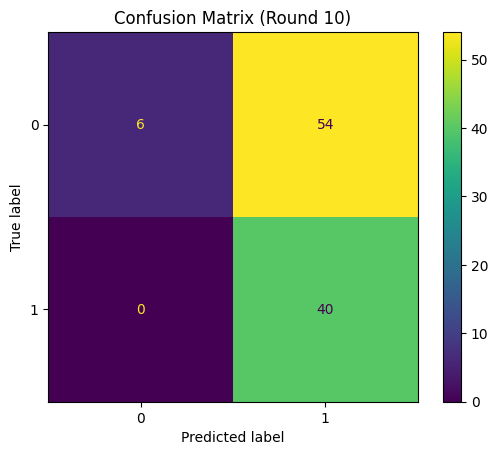

[📊] 🧊 IsolationForest Macro F1 Score: 0.6264
[📊] ⬜ KMeans Macro F1 Score: 0.5810


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:26:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[📊] 🧠 Meta-Classifier (XGBoost) F1 Score: 1.0000 / Accuracy: 1.0000
[📊] 🧬 Compare: Original DAGMM + KMeans Only F1 Score: 0.5810 (vs. Meta: 1.0000)


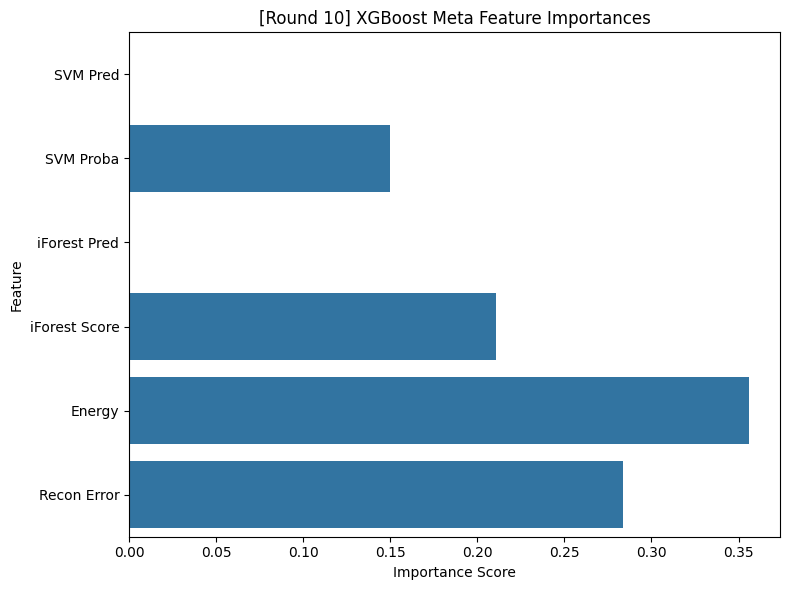

[📁] Saving performance CSV to: c:\Users\USER\jiyeon\pytorch-from-centralized-to-federated\test_parameters\model_performance1.csv


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=35528)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=35528)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=

(ClientAppActor pid=35528) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=11936) 


[INFO] Aggregating results for round 11...


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=31600) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=31600)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=31600)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=33908) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 12...


(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=25220)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=25220)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=35528) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=37340) 


[INFO] Aggregating results for round 13...


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=25220) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 14...


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=29636)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=29636)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=31600) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate

[INFO] Aggregating results for round 15...


(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32592)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32592)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=31600) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=38168) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 16...


(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32592)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32592)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=32592) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=21568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=21568)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=21568)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 17...


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=25220) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38168)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38168)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
INFO :      aggregate_fit: r

[INFO] Aggregating results for round 18...


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) W

(ClientAppActor pid=11936) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=33908)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=33908)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 19...


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=33908)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=33908)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=21568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=29636) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=21568) 


[INFO] Aggregating results for round 20...
[DEBUG] Round 20: 200 embeddings
[INFO] Re-training DAGMM and classifiers with 200 samples...
[INFO] Epoch 10/100 - Loss: 0.8588, Accuracy: 43.00%, F1 Score: 0.3396
[INFO] Epoch 20/100 - Loss: 0.8366, Accuracy: 63.50%, F1 Score: 0.4638
[INFO] Epoch 30/100 - Loss: 0.8209, Accuracy: 63.50%, F1 Score: 0.4638
[INFO] Epoch 40/100 - Loss: 0.8137, Accuracy: 65.00%, F1 Score: 0.4982
[INFO] Epoch 50/100 - Loss: 0.8080, Accuracy: 64.50%, F1 Score: 0.4870
[INFO] Epoch 60/100 - Loss: 0.8028, Accuracy: 65.00%, F1 Score: 0.4982
[INFO] Epoch 70/100 - Loss: 0.8001, Accuracy: 65.00%, F1 Score: 0.4982
[INFO] Epoch 80/100 - Loss: 0.7977, Accuracy: 65.00%, F1 Score: 0.4982
[INFO] Epoch 90/100 - Loss: 0.7953, Accuracy: 65.00%, F1 Score: 0.4982
[INFO] Epoch 100/100 - Loss: 0.7940, Accuracy: 65.00%, F1 Score: 0.4982
[HNM] Round 1: Found 73 hard negatives
[HNM] No hard negatives found at round 2.

[📊] ⬛ Evaluating SVM:
[INFO] SVM Supervised Accuracy: 43.00%
[INFO] SV

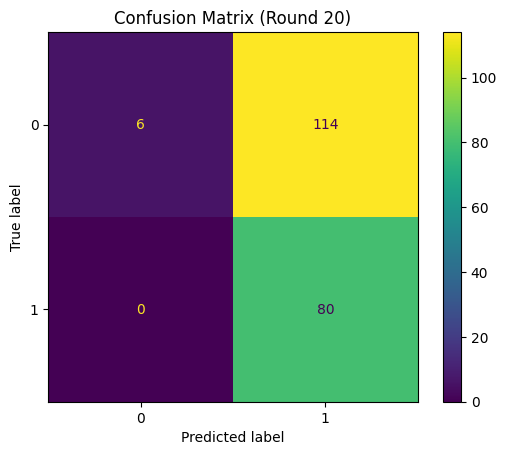

[📊] 🧊 IsolationForest Macro F1 Score: 0.5288
[📊] ⬜ KMeans Macro F1 Score: 0.4519


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:37:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[📊] 🧠 Meta-Classifier (XGBoost) F1 Score: 0.8732 / Accuracy: 0.8850
[📊] 🧬 Compare: Original DAGMM + KMeans Only F1 Score: 0.4519 (vs. Meta: 0.8732)


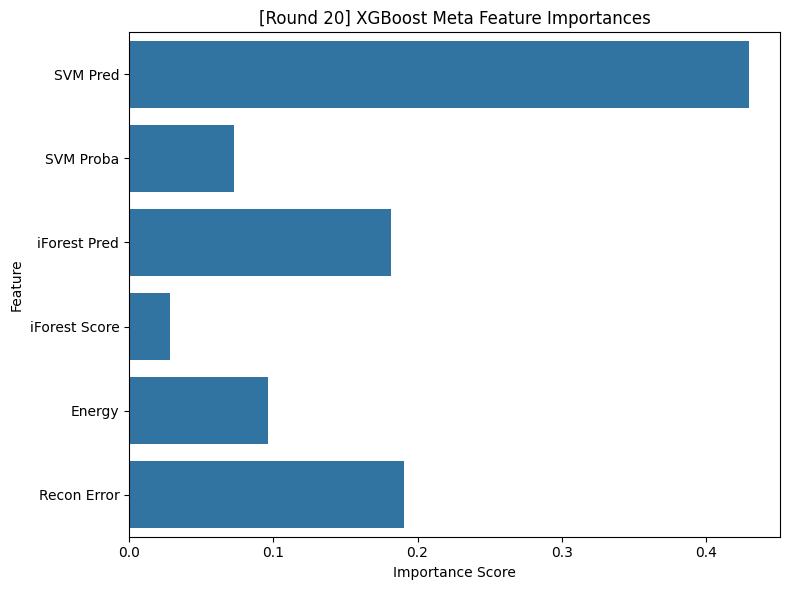

[📁] Saving performance CSV to: c:\Users\USER\jiyeon\pytorch-from-centralized-to-federated\test_parameters\model_performance1.csv


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33908)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33908)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=33908) 


[INFO] Aggregating results for round 21...


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33908)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33908)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=31600) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=29636)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=29636)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate

[INFO] Aggregating results for round 22...


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) W

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 23...


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=21568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=38168) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 24...


(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=25220)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=25220)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=25220) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=29636) 


[INFO] Aggregating results for round 25...


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33908)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33908)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=31600) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 26...


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=25220) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32592)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32592)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

[INFO] Aggregating results for round 27...


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed
(ClientAppActor pid=11936)             entirely in future versions of Flower.
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed
(ClientAppActor pid=37340)             entirely in future versions of Flower.
(ClientAppActor pid=37340)        

(ClientAppActor pid=11936) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 28...


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=21568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=21568)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=21568)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 29...


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=31600) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=31600)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=31600)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=29636) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
INFO :      aggregate_fit: r

[INFO] Aggregating results for round 30...
[DEBUG] Round 30: 300 embeddings
[INFO] Re-training DAGMM and classifiers with 300 samples...
[INFO] Epoch 10/100 - Loss: 0.8629, Accuracy: 55.67%, F1 Score: 0.5180
[INFO] Epoch 20/100 - Loss: 0.8433, Accuracy: 50.67%, F1 Score: 0.5063
[INFO] Epoch 30/100 - Loss: 0.8305, Accuracy: 63.00%, F1 Score: 0.4519
[INFO] Epoch 40/100 - Loss: 0.8240, Accuracy: 62.00%, F1 Score: 0.5180
[INFO] Epoch 50/100 - Loss: 0.8195, Accuracy: 62.33%, F1 Score: 0.5442
[INFO] Epoch 60/100 - Loss: 0.8154, Accuracy: 62.00%, F1 Score: 0.5386
[INFO] Epoch 70/100 - Loss: 0.8133, Accuracy: 62.33%, F1 Score: 0.5442
[INFO] Epoch 80/100 - Loss: 0.8114, Accuracy: 62.67%, F1 Score: 0.5497
[INFO] Epoch 90/100 - Loss: 0.8095, Accuracy: 62.67%, F1 Score: 0.5497
[INFO] Epoch 100/100 - Loss: 0.8084, Accuracy: 62.67%, F1 Score: 0.5497
[HNM] Round 1: Found 113 hard negatives
[HNM] No hard negatives found at round 2.

[📊] ⬛ Evaluating SVM:
[INFO] SVM Supervised Accuracy: 40.00%
[INFO] S

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

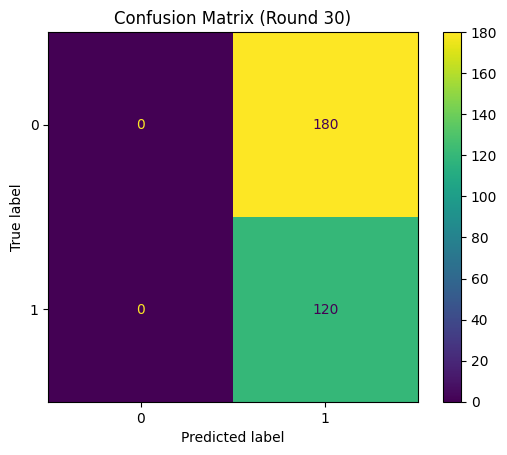

[📊] 🧊 IsolationForest Macro F1 Score: 0.5522
[📊] ⬜ KMeans Macro F1 Score: 0.4357


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:49:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[📊] 🧠 Meta-Classifier (XGBoost) F1 Score: 0.8417 / Accuracy: 0.8600
[📊] 🧬 Compare: Original DAGMM + KMeans Only F1 Score: 0.4357 (vs. Meta: 0.8417)


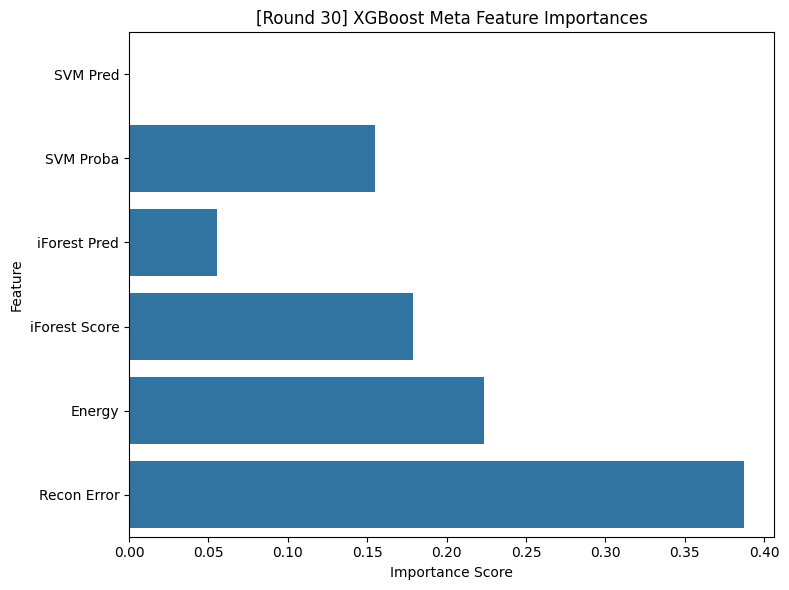

[📁] Saving performance CSV to: c:\Users\USER\jiyeon\pytorch-from-centralized-to-federated\test_parameters\model_performance1.csv


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=35528)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=35528)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=

(ClientAppActor pid=21568) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 31...


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=33908) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=35528)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=35528)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

[INFO] Aggregating results for round 32...


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=29636)             This is a deprecated feature. It will be removed
(ClientAppActor pid=29636)             entirely in future versions of Flower.
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)             This is a deprecated feature. It will be removed
(ClientAppActor pid=25220)             entirely in future versions of Flower.
(ClientAppActor pid=25220)        

(ClientAppActor pid=38168) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 33...


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=29636)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=29636)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=31600) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=11936) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11936)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11936)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
INFO :      aggregate_fit: r

[INFO] Aggregating results for round 34...


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=29636)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=29636)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=11936) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=31600) 


[INFO] Aggregating results for round 35...


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38168)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38168)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=29636) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=11936) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 36...


(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=32592)             This is a deprecated feature. It will be removed
(ClientAppActor pid=32592)             entirely in future versions of Flower.
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed
(ClientAppActor pid=37340)             entirely in future versions of Flower.
(ClientAppActor pid=37340)        

(ClientAppActor pid=21568) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=32592) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=32592)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=32592)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=38168) 


[INFO] Aggregating results for round 37...


(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=38168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38168)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38168)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=37340) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=25220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=25220)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=25220)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate

[INFO] Aggregating results for round 38...


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=31600) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=31600)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=31600)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=32592) 
(ClientAppActor pid=32592)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=35528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=11936) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[INFO] Aggregating results for round 39...


(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=31600) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=31600)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=31600)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=35528) 
(ClientAppActor pid=35528)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=33908) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signatu

(ClientAppActor pid=35528) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=21568) 
(ClientAppActor pid=21568)         
(ClientAppActor pid=31600) 
(ClientAppActor pid=31600)         
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 40...
[DEBUG] Round 40: 400 embeddings
[INFO] Re-training DAGMM and classifiers with 400 samples...
[INFO] Epoch 10/100 - Loss: 0.8776, Accuracy: 63.00%, F1 Score: 0.4519
[INFO] Epoch 20/100 - Loss: 0.8655, Accuracy: 41.25%, F1 Score: 0.3118
[INFO] Epoch 30/100 - Loss: 0.8513, Accuracy: 59.25%, F1 Score: 0.5014
[INFO] Epoch 40/100 - Loss: 0.8465, Accuracy: 58.25%, F1 Score: 0.5131
[INFO] Epoch 50/100 - Loss: 0.8420, Accuracy: 58.25%, F1 Score: 0.5357
[INFO] Epoch 60/100 - Loss: 0.8383, Accuracy: 58.25%, F1 Score: 0.5357
[INFO] Epoch 70/100 - Loss: 0.8362, Accuracy: 60.50%, F1 Score: 0.5363
[INFO] Epoch 80/100 - Loss: 0.8343, Accuracy: 59.75%, F1 Score: 0.5366
[INFO] Epoch 90/100 - Loss: 0.8322, Accuracy: 59.75%, F1 Score: 0.5366
[INFO] Epoch 100/100 - Loss: 0.8310, Accuracy: 61.25%, F1 Score: 0.5481
[HNM] Round 1: Found 149 hard negatives
[HNM] No hard negatives found at round 2.

[📊] ⬛ Evaluating SVM:
[INFO] SVM Supervised Accuracy: 40.00%
[INFO] S

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

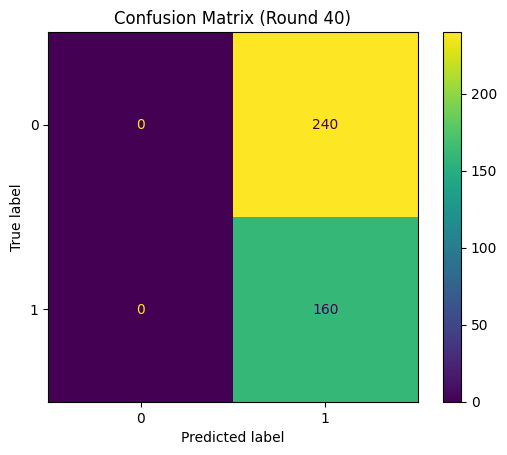

[📊] 🧊 IsolationForest Macro F1 Score: 0.5824
[📊] ⬜ KMeans Macro F1 Score: 0.3750


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:02:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[📊] 🧠 Meta-Classifier (XGBoost) F1 Score: 0.7823 / Accuracy: 0.8125
[📊] 🧬 Compare: Original DAGMM + KMeans Only F1 Score: 0.3750 (vs. Meta: 0.7823)


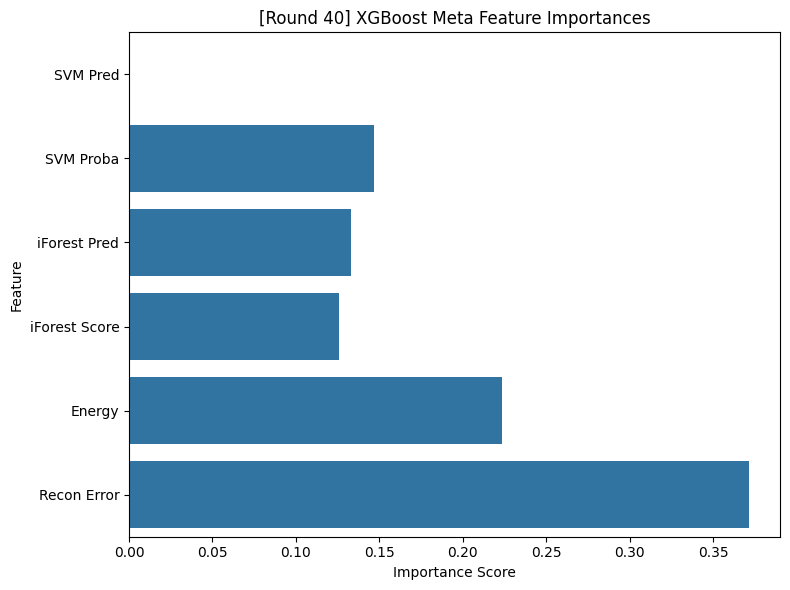

[📁] Saving performance CSV to: c:\Users\USER\jiyeon\pytorch-from-centralized-to-federated\test_parameters\model_performance1.csv


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=37340) 
(ClientAppActor pid=37340)         
(ClientAppActor pid=37340) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37340)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37340)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33908) 
(ClientAppActor pid=33908)         
(ClientAppActor pid=11936) 
(ClientAppActor pid=11936)         
(ClientAppActor pid=25220) 
(ClientAppActor pid=25220)         
(ClientAppActor pid=38168) 
(ClientAppActor pid=38168)         
(ClientAppActor pid=29636) 
(ClientAppActor pid=29636)         
(ClientAppActor pid=

In [16]:
# --- 학습 시작 ---
def start_federated_learning():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    full_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    partitions = [Subset(full_data, idx) for idx in np.array_split(np.random.permutation(len(full_data)), 10)]
    tracker = ClientTracker()

    labels = ["normal"] * 5 + ["lazy", "random", "echo", "small", "normal"]
    clients = [make_client(i, partitions[i], labels[i]) for i in range(10)]

    pool = PunishedClientPool(clients, partitions)

    fl.simulation.start_simulation(
        client_fn=pool.get_client_fn(),
        num_clients=10,
        config=fl.server.ServerConfig(num_rounds=40),
        strategy=CustomFedAvgWcithDetection(pool, "dagmm_meta3_80.pth", "svm_meta4_80.pkl", "iforest_meta4_80.pkl", tracker)
    )

if __name__ == "__main__":
    start_federated_learning()